In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import lightkurve as lk
import numpy as np

In [2]:
def plot_pixel_level_LC(tpf, transit_time, ql = False):
    
    transit_list = [transit_time]
    t_list = [tpf.time.value]
    tpf_list = [tpf.flux.value]
    bkg_list = [np.nanmean(tpf.flux.value,axis = 0)]
    arrshape_list = [tpf.flux.shape]
    tpf_pipeline_mask = tpf.pipeline_mask

    # loop through the transits and make plot for each ( only the first is currently displayed in the pdf report)
    for idx, X1_original in enumerate(tpf_list):

        bkg = np.flip(bkg_list[idx], axis = 0)
        arrshape = arrshape_list[idx]
        peak = transit_list[idx]
        tpf = tpf_list[idx]
        
        s = X1_original.shape
        X1 = X1_original.reshape(s[0],s[1]*s[2])
        
        T0 = transit_list[idx] # the time of the transit-like event
        t = t_list[idx] # the time array

        intr = abs(T0-t) < 0.25  # create a mask of the in transit times
        oot = (abs(T0-t) < 0.5) * (abs(T0-t) < 0.3)  # create a mask of the out of transit times
        

        fig, ax = plt.subplots(arrshape[1], arrshape[2], sharex = True, sharey = False, gridspec_kw={'hspace': 0 ,'wspace': 0}, figsize=(5.5,5.5))

        plt.tight_layout()

        # see if the backrgound of this plot can be the average pixel flux (if there are too many nans this will fail and the background will just be black which is also okay)
        try:
            color = plt.cm.viridis(np.linspace(0, 1,int(np.nanmax(bkg))-int(np.nanmin(bkg))+1))
            simplebkg = False
        except:
            simplebkg = True

        for i in range(0,arrshape[1]):
            ii = arrshape[1]-1-i # we want to plot this such that the pixels increase from left to right and bottom to top

            for j in range(0,arrshape[2]):
                try:
                    if tpf_pipeline_mask[i, j]:
                        rect = Rectangle((0, 0), 1, 1, linewidth=3, edgecolor='red', facecolor='none', transform=ax[ii, j].transAxes)
                        ax[ii, j].add_patch(rect)
                except:
                    pass

                apmask = np.zeros(arrshape[1:], dtype=int)
                apmask[i,j] = 1
                apmask = apmask.astype(bool)
                
                flux = X1[:,apmask.flatten()].sum(axis=1)

                m = np.nanmedian(flux[oot])

                normalizedflux = flux/m

                # bin the data
                f1 = normalizedflux
                time = t


                binfac = 7

                N       = len(time)
                n       = int(np.floor(N/binfac)*binfac)
                X       = np.zeros((2,n))
                X[0,:]  = time[:n]
                X[1,:]  = f1[:n]
                Xb      = rebin(X, (2,int(n/binfac)))

                # binned data
                time_binned    =    np.array(Xb[0])
                flux_binned    =   np.array(Xb[1])

                
                # create a mask that only looks at the times cut around the transit-event
                timemask = (time_binned < peak+1.5) & (time_binned > peak-1.5)

                time_binned = time_binned[timemask]
                flux_binned = flux_binned[timemask]

                # make sure that there are no nan (empty) values in the data - they cause everything to crash so let's get rid of them
                mask_binned = np.isfinite(time_binned) * np.isfinite(flux_binned)
                time_binned = np.array(time_binned)[mask_binned]
                flux_binned = np.array(flux_binned)[mask_binned]

                # ----------
                # fit a spline to the cut-out of each pixel LC in order to flatten it
                p = np.poly1d(np.polyfit(time_binned, flux_binned, 3))
                flux_binned = flux_binned/p(time_binned)
                # ----------

                intr = abs(peak-time_binned) < 0.1

                if simplebkg == True:
                    ax[ii, j].set_facecolor(color = 'k')
                    linecolor = 'w'
                    transitcolor = 'gold'
                else:
                    ax[ii, j].set_facecolor(color = color[int(bkg[ii,j])-int(np.nanmin(bkg))])

                    if int(bkg[ii,j])-abs(int(np.nanmin(bkg))) > ((np.nanmax(bkg))-abs(int(np.nanmin(bkg))))/2:
                        linecolor = 'k'
                        transitcolor = 'orangered'
                    else:
                        linecolor = 'w'
                        transitcolor = 'gold'


                ax[ii, j].plot(time_binned,flux_binned, color = linecolor, marker = '.', markersize=1, lw = 0)
                ax[ii, j].plot(time_binned[intr],flux_binned[intr], color = transitcolor, marker = '.', markersize=1, lw = 0)

                # get rid of ticks and ticklabels
                ax[ii,j].set_yticklabels([])
                ax[ii,j].set_xticklabels([])
                ax[ii,j].set_xticks([])
                ax[ii,j].set_yticks([])

        # ------------------

        print ("done.\n")
        # ------------------

        # label the pixels

        fig.text(0.5,0.01, "column (pixel)", ha='center', fontsize = 13)
        fig.text(0.01, 0.5, "row (pixel)", va='center', rotation='vertical', fontsize = 13)

        # - - - - - - - - - -

        plt.subplots_adjust(top=0.95, right = 0.99, bottom = 0.04, left = 0.04)

        plt.suptitle(r"T0 = {} $\pm$ 1.5 d".format(peak ),y=0.98, fontsize = 12)
        plt.xlim(peak-1.5,peak+1.5)
        plt.show()
        
        
def rebin(arr,new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
        new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)


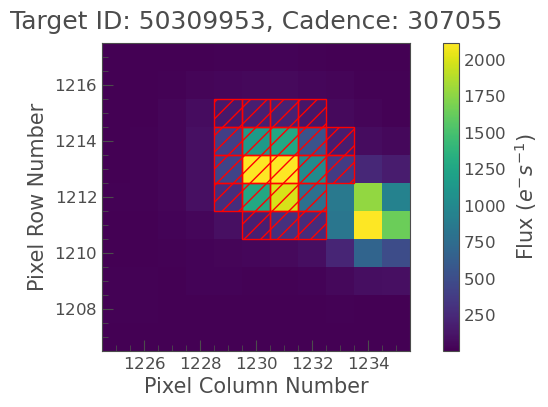

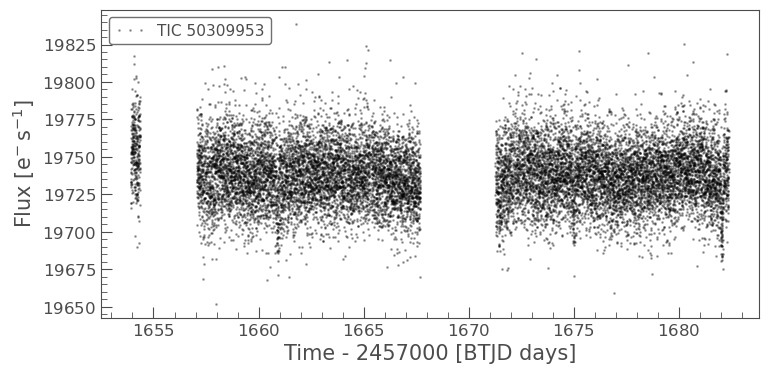

In [34]:
TIC = "TIC 50309953"

search_result = lk.search_targetpixelfile(TIC, author="SPOC", sector = 13)[0]
tpf = search_result.download()
tpf.plot(aperture_mask="pipeline")

sector_data = lk.search_lightcurve(TIC, author = "SPOC", sector = 13)[0]

lc = sector_data.download()
lc.plot(linewidth = 0, marker = ".", color = "black", alpha = 0.3)
plt.show()

done.



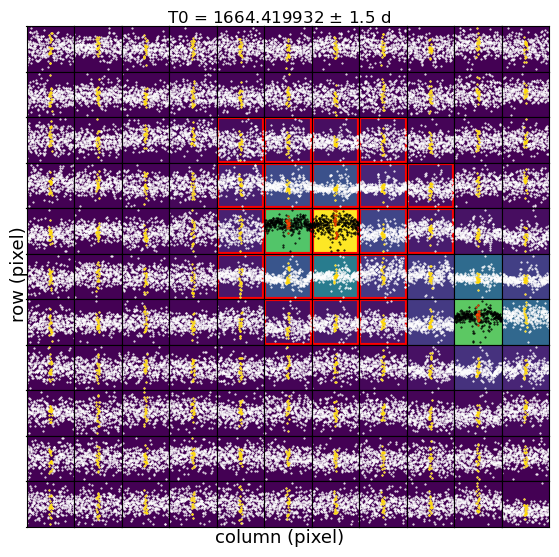

In [37]:
transit_time = 1660.899932 + 3.52

plot_pixel_level_LC(tpf, transit_time)